Fit did not converge for parameters: A=0.8333333333333333, f=0.004166666666666667, phi=-0.34906585039886595, C=0.11111111111111116
Fit did not converge for parameters: A=1.1666666666666665, f=0.004166666666666667, phi=2.443460952792061, C=-0.11111111111111116
Fit did not converge for parameters: A=1.8333333333333333, f=0.008333333333333333, phi=1.0471975511965974, C=0.7777777777777777
Rat T2: Circular Corr: -0.19, p-value: 0.000
Fit did not converge for parameters: A=0.5, f=0.024999999999999998, phi=0.34906585039886595, C=-0.7777777777777778
Fit did not converge for parameters: A=0.5, f=0.024999999999999998, phi=0.34906585039886595, C=-0.5555555555555556
Rat T3: Circular Corr: 0.12, p-value: 0.040
Rat T4: Circular Corr: -0.26, p-value: 0.000
Rat T5: Circular Corr: 0.14, p-value: 0.007
Rat T6: Circular Corr: -0.11, p-value: 0.015
Rat T7: Circular Corr: 0.07, p-value: 0.009


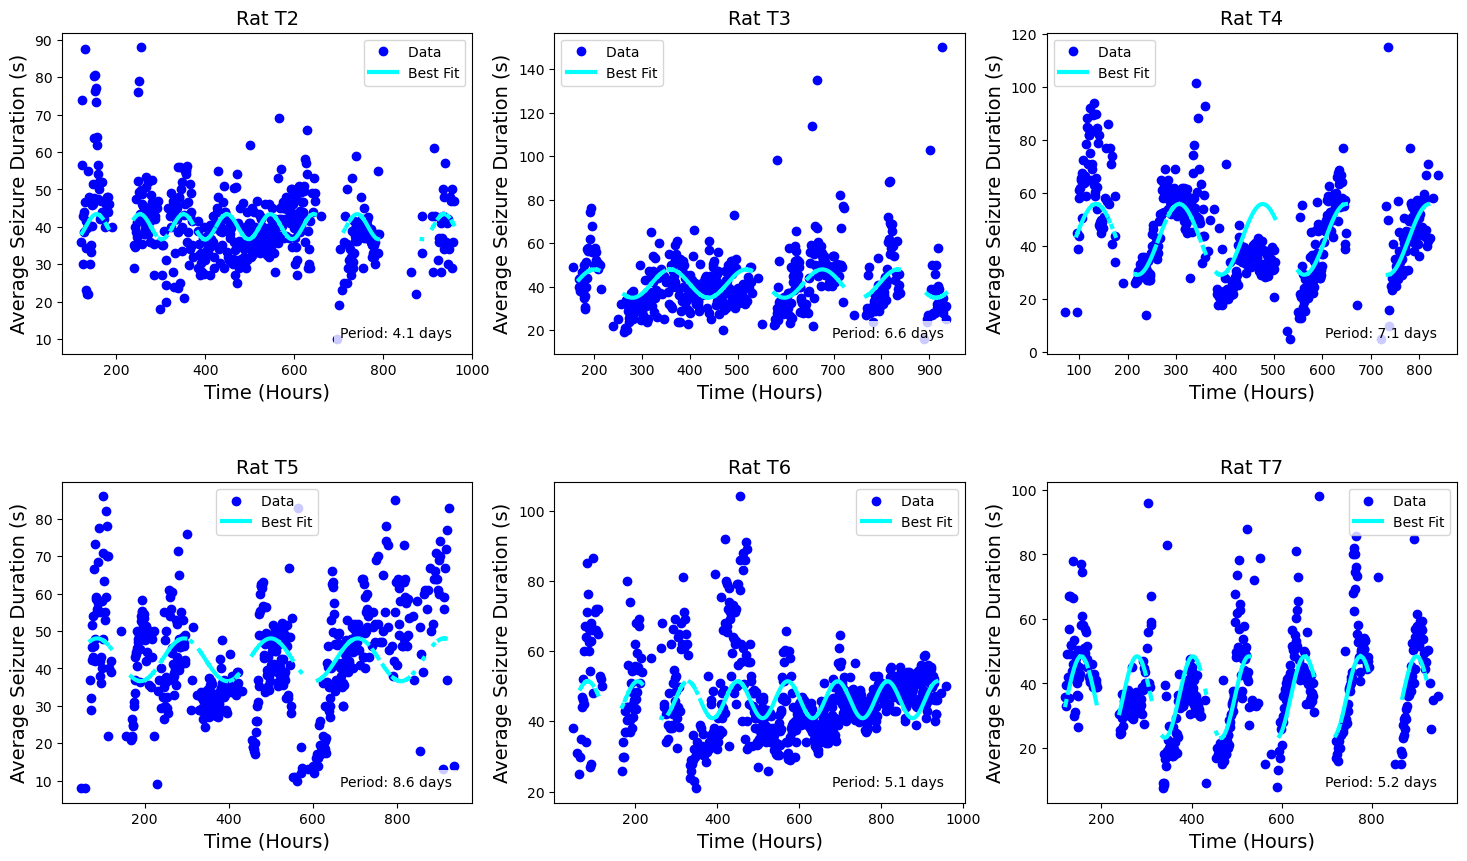

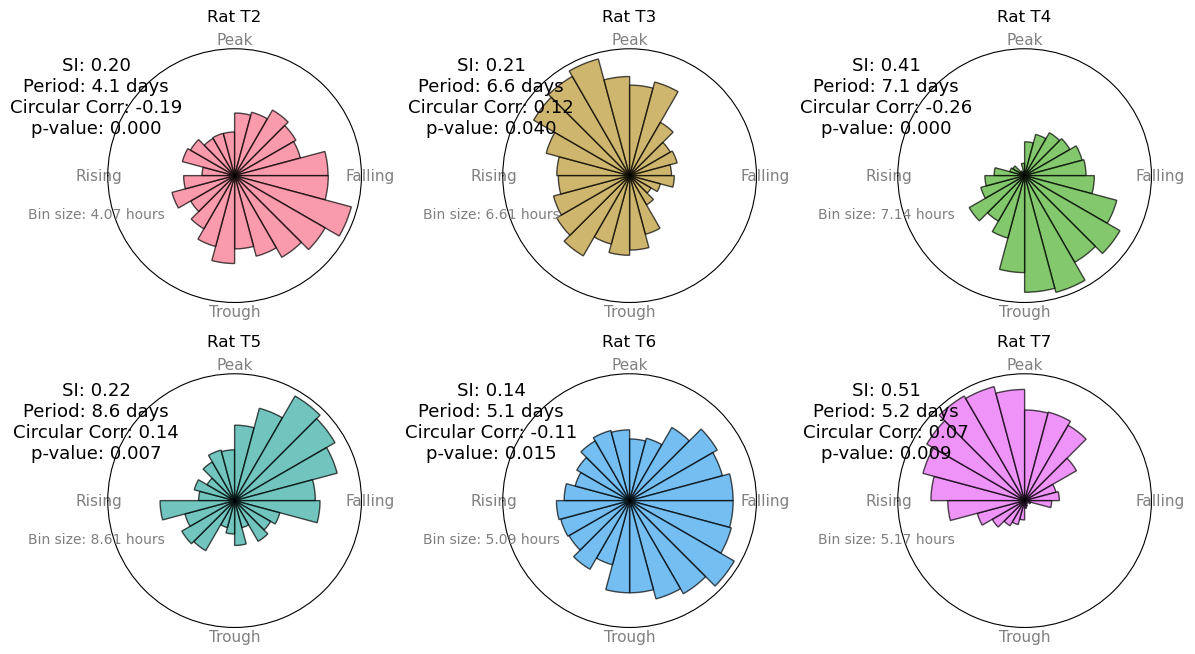

In [3]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.io import loadmat
import seaborn as sns

# Define the sinusoidal model
def sinusoidal_model(t, A, f, phi, C):
    return A * np.sin(2 * np.pi * f * t + phi) + C

# Function to calculate RMSE
def calculate_rmse(data, model):
    return np.sqrt(np.mean((data - model) ** 2))

# Circular-linear correlation based on Kempter et al. (2012)
def circular_linear_corr_kempter(phases, durations):
    n = len(phases)
    sin_diff = np.sin(phases - np.mean(phases))
    dur_diff = durations - np.mean(durations)

    numerator = np.sum(sin_diff * dur_diff)
    denominator_x = np.sqrt(np.sum(dur_diff ** 2))
    denominator_theta = np.sqrt(np.sum(sin_diff ** 2))

    corr = numerator / (denominator_x * denominator_theta)
    return corr

# Function to calculate p-value using permutation test
def permutation_test_kempter(phases, durations, observed_corr, num_permutations=100000):
    permuted_corrs = []
    for _ in range(num_permutations):
        # Randomly shuffle the durations
        shuffled_durations = np.random.permutation(durations)
        # Calculate circular-linear correlation for shuffled data
        perm_corr = circular_linear_corr_kempter(phases, shuffled_durations)
        permuted_corrs.append(perm_corr)
    
    # Compute the p-value: proportion of permuted correlations that are as extreme as the observed one
    extreme_count = np.sum(np.abs(permuted_corrs) >= np.abs(observed_corr))
    
    # Avoid p-value being exactly zero by adding a small pseudocount
    p_value = (extreme_count + 1) / (num_permutations + 1)  # Adding 1 to avoid 0 p-value
    return p_value

# Function to calculate SI
def calculate_si_index(seizure_phases):
    seizure_phases_float = [float(phase) for phase in seizure_phases]
    complex_exponentials = np.exp(1j * np.array(seizure_phases_float))
    mean_resultant_vector = np.mean(complex_exponentials)
    SI = round(np.abs(mean_resultant_vector), 2)
    return SI

# Load the data from the MATLAB .mat file
mat_data = loadmat('All_rats_daily_seizure_duration_nan.mat')
All_rats_daily_seizure_duration = mat_data['All_rats_daily_seizure_duration']

# Parameter ranges
amplitude_guesses = np.linspace(0.5, 2, 10)  # Amplitude guesses
frequency_guesses = np.linspace(1/240, 1/24, 10)  # Frequency guesses (from 240 hours to 24 hours)
phase_guesses = np.linspace(-np.pi, np.pi, 10)   # Phase guesses
offset_guesses = np.linspace(-1, 1, 10)          # Offset guesses

# Create subplots for the sinusoidal fits and the polar plots
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
fig_polar, axs_polar = plt.subplots(2, 3, subplot_kw={'polar': True}, figsize=(12, 7))
colors = sns.color_palette("husl", 6)

# Loop over each rat's data to fit the sinusoidal model and calculate the correlation
for rat_idx, (ax, ax_polar, rat_data) in enumerate(zip(axs.flatten(), axs_polar.flatten(), All_rats_daily_seizure_duration[0]), start=1):
    rat_data = rat_data.T
    duration_data = rat_data.flatten()
    
    # Define time points corresponding to the hours over 40 days (0 to 959)
    time_points = np.arange(duration_data.size)
    
    # Exclude NaN values
    valid_idx = ~np.isnan(duration_data)
    valid_times = time_points[valid_idx]
    valid_durations = duration_data[valid_idx]

    best_params = None
    best_rmse = np.inf

    # Iterate over parameter guesses
    for A in amplitude_guesses:
        for freq in frequency_guesses:
            for phi in phase_guesses:
                for C in offset_guesses:
                    current_guess = [A, freq, phi, C]
                    
                    try:
                        # Fit the sinusoidal model
                        popt, _ = curve_fit(sinusoidal_model, valid_times, valid_durations, p0=current_guess)
                        # Calculate RMSE
                        fitted_values = sinusoidal_model(valid_times, *popt)
                        rmse = calculate_rmse(valid_durations, fitted_values)

                        # Extract the best frequency and compute the period
                        best_frequency = popt[1]
                        best_period = 1 / best_frequency if best_frequency != 0 else np.nan  # Avoid division by zero
                        
                        # Check if the current RMSE is better (lower) than the best RMSE found
                        if rmse < best_rmse and best_period < 240 and best_period > 0:
                            best_rmse = rmse
                            best_params = popt

                    except RuntimeError:
                        print(f"Fit did not converge for parameters: A={A}, f={freq}, phi={phi}, C={C}")

    # Extract the best frequency and compute the period
    if best_params is not None:
        best_frequency = best_params[1]
        best_period = 1 / best_frequency if best_frequency != 0 else np.nan  # Avoid division by zero

        # Plot the data
        masked_durations = np.ma.masked_where(np.isnan(duration_data), duration_data)
        ax.plot(time_points, masked_durations, 'bo', label='Data ')

        # Plot the sinusoidal fit
        fitted_curve = sinusoidal_model(time_points, *best_params)
        masked_fitted_curve = np.ma.masked_where(np.isnan(duration_data), fitted_curve)
        fig, ax.plot(time_points, masked_fitted_curve, 'cyan', label='Best Fit', linewidth=3)
        ax.set_title(f'Rat T{rat_idx+1}', fontsize=14)
        ax.set_xlabel('Time (Hours)', fontsize=14)
        ax.set_ylabel('Average Seizure Duration (s)', fontsize=14)
        ax.legend()
        fig.subplots_adjust(hspace=0.4)

        # Annotate the period on the subplot
        ax.text(0.95, 0.05, f'Period: {best_period / 24:.1f} days', transform=ax.transAxes,
                ha='right', fontsize=10, color='black', bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

        # Polar plot and phase calculation
        seizure_timestamps = []
        for hour, count in enumerate(duration_data):
            if np.isfinite(count) and count > 0:
                seizure_timestamps.extend([hour] * int(count))

        cycle_length = best_period
        phase_values = [(timestamp % cycle_length) * (2 * np.pi / cycle_length) for timestamp in seizure_timestamps]
           # Collect positional phase and corresponding seizure duration
        phases_durations = []
        for idx, phase in enumerate(phase_values):
             if idx < len(duration_data) and not np.isnan(duration_data[idx]):
                 phases_durations.append((phase, duration_data[idx]))
        
        if phases_durations:
           phases_durations = np.array(phases_durations)
           phases = phases_durations[:, 0]
           durations = phases_durations[:, 1]
    

        # Calculate circular-linear correlation and p-value using Kempter's method
        if len(phases) > 0 and len(durations) > 0:
            corr = circular_linear_corr_kempter(phases, durations)
            p_value = permutation_test_kempter(phases, durations, corr)
            p_value=p_value*6
            print(f"Rat T{rat_idx+1}: Circular Corr: {corr:.2f}, p-value: {p_value:.3f}")

            # Polar plot for phase histogram
            hist, bin_edges = np.histogram(phase_values, bins=24, range=(0, 2 * np.pi))
            ax_polar.bar(bin_edges[:-1], hist, color=colors[rat_idx - 1], edgecolor='black', fill=True, alpha=0.7, width=(2 * np.pi) / 24, align='edge')
            ax_polar.set_xticks([np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi])
            ax_polar.set_xticklabels(['Peak', 'Falling', 'Trough', 'Rising'], fontsize=11, color='grey')
            ax_polar.set_yticks([])
            ax_polar.tick_params(axis='both', pad=-4)
            ax_polar.grid(False)
            ax_polar.set_theta_zero_location('W')
            ax_polar.set_theta_direction(-1)
            ax_polar.set_rlabel_position(90)
            ax_polar.set_title(f'Rat T{rat_idx+1}', fontsize=12, pad=20)

            SI = calculate_si_index(phase_values)
            bin_size_hours = cycle_length / 24
            ax_polar.text(-0.3, 1.2 * max(hist), f'Bin size: {bin_size_hours:.2f} hours', ha='center', fontsize=10, color='grey')
            ax_polar.text(0.3, 1.2 * max(hist), f'SI: {SI:.2f}\nPeriod: {cycle_length / 24:.1f} days\nCircular Corr: {corr:.2f}\np-value: {p_value:.3f}', ha='center', fontsize=13, color='black')
        else:
            ax.set_title(f'Rat T{rat_idx}', fontsize=14)
            ax.set_xlabel('Time (Hours)', fontsize=14)
            ax.set_ylabel('Average Seizure Duration (s)', fontsize=14)
            ax.text(0.5, 0.5, 'No Fit', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('sinusoidal_fits_with_polar_kempter.png', dpi=300)
plt.show()


Fit did not converge for segment 5
Fit did not converge for segment 5
Fit did not converge for segment 5
Fit did not converge for segment 5
Fit did not converge for segment 5
Fit did not converge for segment 5
Fit did not converge for segment 5
Fit did not converge for segment 5
Fit did not converge for segment 5
Fit did not converge for segment 5
Fit did not converge for segment 5
Fit did not converge for segment 5
Fit did not converge for segment 5
Fit did not converge for segment 5
Fit did not converge for segment 5
Fit did not converge for segment 5
Fit did not converge for segment 5
Fit did not converge for segment 5
Fit did not converge for segment 5
Fit did not converge for segment 5
Fit did not converge for segment 5
Fit did not converge for segment 5
Fit did not converge for segment 5
Fit did not converge for segment 5
Fit did not converge for segment 5
Fit did not converge for segment 5
Fit did not converge for segment 5
Fit did not converge for segment 6
Fit did not converge

/var/folders/cp/xdcwkfp505g52zllx01s3q2w0000gp/T/ipykernel_20441/1932399751.py:197: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


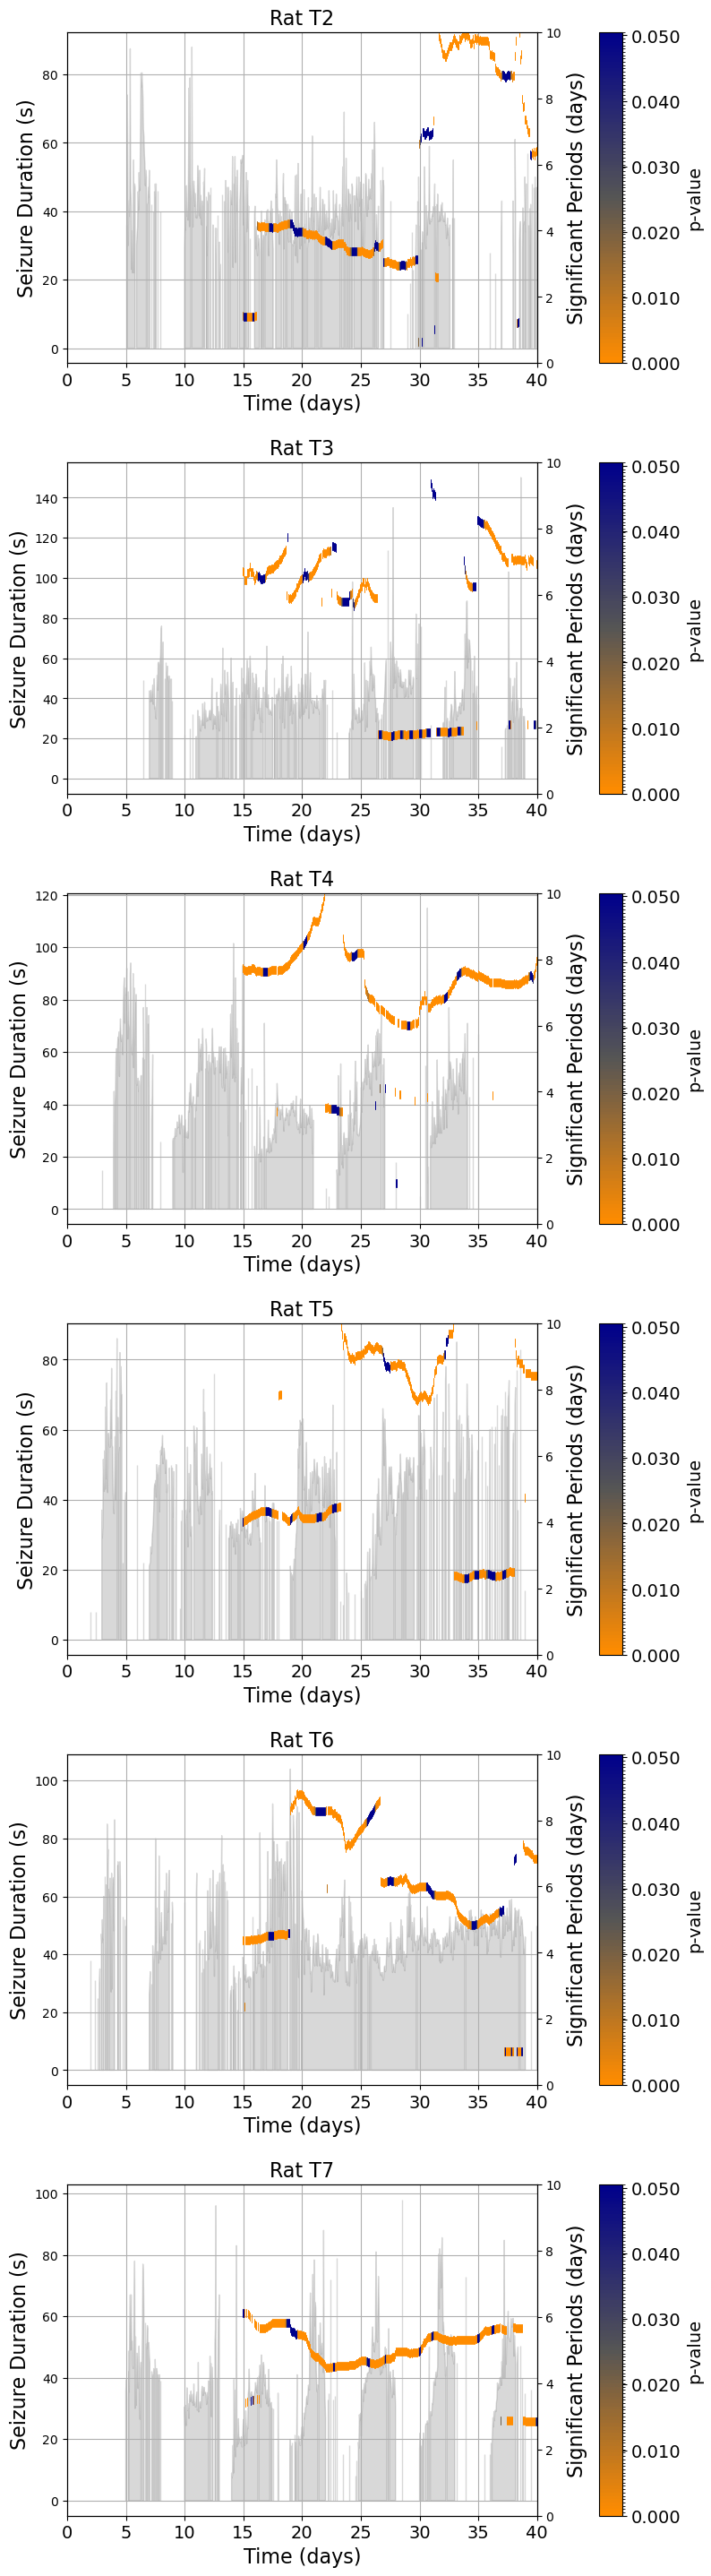

In [2]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.io import loadmat
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap


# Define the sinusoidal model
def sinusoidal_model(t, A, f, phi, C):
    return A * np.sin(2 * np.pi * f * t + phi) + C

# Function to calculate RMSE
def calculate_rmse(data, model):
    return np.sqrt(np.mean((data - model) ** 2))

# Circular-linear correlation based on Kempter et al. (2012)
def circular_linear_corr_kempter(phases, durations):
    n = len(phases)
    sin_diff = np.sin(phases - np.mean(phases))
    dur_diff = durations - np.mean(durations)

    numerator = np.sum(sin_diff * dur_diff)
    denominator_x = np.sqrt(np.sum(dur_diff ** 2))
    denominator_theta = np.sqrt(np.sum(sin_diff ** 2))

    corr = numerator / (denominator_x * denominator_theta)
    return corr

# Function to calculate p-value using permutation test
def permutation_test_kempter(phases, durations, observed_corr, num_permutations=100000):
    permuted_corrs = []
    for _ in range(num_permutations):
        # Randomly shuffle the durations
        shuffled_durations = np.random.permutation(durations)
        # Calculate circular-linear correlation for shuffled data
        perm_corr = circular_linear_corr_kempter(phases, shuffled_durations)
        permuted_corrs.append(perm_corr)
    
    # Compute the p-value: proportion of permuted correlations that are as extreme as the observed one
    extreme_count = np.sum(np.abs(permuted_corrs) >= np.abs(observed_corr))
    
    # Avoid p-value being exactly zero by adding a small pseudocount
    p_value = (extreme_count + 1) / (num_permutations + 1)  # Adding 1 to avoid 0 p-value
    return p_value

# Load the data from the MATLAB .mat file
mat_data = loadmat('All_rats_daily_seizure_duration_nan.mat')
All_rats_daily_seizure_duration = mat_data['All_rats_daily_seizure_duration']

# Parameters
hours_per_day = 24
segment_length_hours = 15 * 24  # Length of each segment in hours
overlap_hours = 359            # Overlap between segments in hours
total_hours = 40 * 24          # Total duration in hours

# Automatically define segment times based on segment length and overlap
segment_times = {}
for seg_idx in range(1, total_hours - overlap_hours + 1):  # Segments starting from 1
    start_time = (seg_idx - 1) * (segment_length_hours - overlap_hours)
    end_time = start_time + segment_length_hours
    segment_times[seg_idx] = {'start': start_time, 'end': end_time}

# Define rat names explicitly from T2 to T7
rat_names = [f'Rat T{i}' for i in range(2, 8)]

# Create a figure and GridSpec layout
n_rats = len(rat_names)
fig = plt.figure(figsize=(8, 6 * n_rats))
gs = gridspec.GridSpec(n_rats, 2, width_ratios=[10, 0.5], wspace=0.25)

# Parameter ranges
amplitude_guesses = np.linspace(0.5, 2, 3)  # Amplitude guesses
frequency_guesses = np.linspace(1/240, 1/24, 10)  # Frequency guesses (from 240 hours to 24 hours)
phase_guesses = np.linspace(-np.pi, np.pi, 3)   # Phase guesses
offset_guesses = np.linspace(-1, 1, 3) 
# Colormap setup
colors = ['darkorange', '#555555', 'darkblue']  # Orange → Gray → Blue



# Create the colormap
cmap = LinearSegmentedColormap.from_list("orange_to_blue", colors, N=256)




# Define boundaries for color mapping: values up to 0.05 will be mapped to a gradient, everything above will be one color
boundaries = np.linspace(0, 0.05, 100)
extended_boundaries = np.concatenate([boundaries, [1]])  # Everything above 0.05 gets mapped to the last color
norm = mcolors.BoundaryNorm(boundaries=extended_boundaries, ncolors=cmap.N, clip=True)

# Loop through each rat to create subplots and color bars
for i, rat in enumerate(rat_names):
    ax = plt.subplot(gs[i, 0])  # Main axis for seizure duration
    ax2 = ax.twinx()  # Twin axis for significant periods (right y-axis)

    # Extract rat-specific data
    rat_data = All_rats_daily_seizure_duration[0][i].T.flatten()

    # Plot the seizure duration data as a histogram on the left y-axis
    ax.fill_between(range(total_hours), 0, rat_data, color='grey', alpha=0.3)

    # Set labels for left and right y-axis
    ax.set_ylabel('Seizure Duration (s)', fontsize=16)
    ax2.set_ylabel('Significant Periods (days)', fontsize=16)

    # Iterate over each segment and fit the sinusoidal model
    for seg_idx, times in segment_times.items():
        start_time = times['start']
        end_time = times['end']
        segment_data = rat_data[start_time:end_time]
        time_points = np.arange(segment_data.size)

        # Exclude NaN values
        valid_idx = ~np.isnan(segment_data)
        valid_times = time_points[valid_idx]
        valid_durations = segment_data[valid_idx]

        best_params = None
        best_rmse = np.inf

        # Iterate over parameter guesses to find the best fit
        for A in amplitude_guesses:
            for freq in frequency_guesses:
                for phi in phase_guesses:
                    for C in offset_guesses:
                        current_guess = [A, freq, phi, C]
                        try:
                            # Fit the sinusoidal model
                            popt, _ = curve_fit(sinusoidal_model, valid_times, valid_durations, p0=current_guess)
                            # Calculate RMSE
                            fitted_values = sinusoidal_model(valid_times, *popt)
                            rmse = calculate_rmse(valid_durations, fitted_values)

                            # Extract the best frequency and compute the period
                            best_frequency = popt[1]
                            best_period = 1 / best_frequency if best_frequency != 0 else np.nan

                            # Check if the current RMSE is better (lower) than the best RMSE found
                            if rmse < best_rmse and best_period < 240 and best_period > 0:
                                best_rmse = rmse
                                best_params = popt
                        except RuntimeError:
                            print(f"Fit did not converge for segment {seg_idx}")

        # Plot significant period as a horizontal line on the right axis, only for the last hour
        if best_params is not None:
            best_frequency = best_params[1]
            best_period = 1 / best_frequency if best_frequency != 0 else np.nan  # Avoid division by zero
            peak_period = best_period / 24  # Convert hours to days

            # Calculate circular-linear correlation and p-value
            seizure_phases = valid_times % best_period * (2 * np.pi / best_period)
            if len(seizure_phases) > 0 and len(valid_durations) > 0:
                corr = circular_linear_corr_kempter(seizure_phases, valid_durations)
                p_value = permutation_test_kempter(seizure_phases, valid_durations, corr)

                # Clip p-values above 0.05 to 0.05 so they map to the same color
                clipped_p_value = min(p_value, 0.05)

                # Map the clipped p-value to color
                color = cmap(norm(clipped_p_value))

                # Plot significant period as a horizontal line (for the last hour) with color based on p-value
                ax2.hlines(peak_period, end_time - 1, end_time, colors=[color], linewidth=7)

    # Customize the plot appearance
    ax.set_xlabel('Time (days)', fontsize=16)
    ax.set_xlim(0, total_hours)
    ax2.set_ylim(0, 240 / 24)  # Set y-axis limit to 10 days (240 hours / 24)

    # Adjust x-axis to show days
    x_ticks = np.arange(0, total_hours + 1, 24 * 5)
    day_labels = [str(int(x / 24)) for x in x_ticks]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(day_labels, fontsize=14)

    ax.set_title(f'{rat}', fontsize=16)
    ax.grid(True)

    # Add a color bar similar to d_prime in the second example
    cbar_ax = plt.subplot(gs[i, 1])
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cbar_ax, orientation='vertical')
    cbar.ax.tick_params(labelsize=14)
    tick_labels = np.around(np.linspace(0, 0.05, 6), decimals=3)
    cbar.set_ticks(tick_labels)
    cbar.set_ticklabels([f'{tick:.3f}' for tick in tick_labels])
    cbar.set_label('p-value', fontsize=14)

# Adjust layout and show plot
plt.subplots_adjust(wspace=0.25, hspace=0.3)
plt.tight_layout()
plt.show()
